# Assignment 6

### 1.复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

### 2.回答以下理论题目?

#### 1. Compared to FNN, what is the biggest advantage of CNN?

回答：全连接神经网络和卷积神经网络对比，CNN的最大优势是：卷积层对目标进行分块，对每一块进行特征处理，从而提取特征；池化层通过对提取的高维特征进行降维；参数减少，计算速度增加。

#### 2. Suppose your input is a 100 by 100 gray image, and you use a convolutional layer with 50 filters that are each 5x5. How many parameters does this hidden layer have (including the bias parameters)? 

回答：(5 * 5 * 1 + 1) * 50 = 1300

#### 3. What are "local invariant" and "parameter sharing" ?

回答：参数共享和平移不变性：用CNN识别一张图片时，由卷积核可得到某物体的feature map；当物体移动到其他地方时，因为参数共享的原因，用同样的卷积核也会 得到相同的feature map进而识别出此物体，这就是参数共享带来的平移不变性，当识别出一个物体时，无论物体移动到什么地方都可以被识别出来。

#### 4. Why we use batch normalization ?

回答：

什么是 Batch Normalization？
从名字上可以看出，是一种批（batch）归一化的操作。就像对输入层的输入特征进行归一化一样，BN 也可以加速模型学习的过程。

为什么使用 Batch Normalization

1、消除 Internal Covariate Shift（由于训练期间网络参数的变化导致的网络激活分布的变化）

2、防止梯度消失：在使用 sigmoid 和 tanh 等激活函数的时候，如果输入过大，将会造成梯度消失的后果。而在使用激活函数之前。对输入进行归一化，则将特征进行了缩减，使其分布集中在非线性激活区域。

3、起到轻微的正则化效果：在 Batch Normalization 的过程中，在每个 mini-batch 中，在神经网络的每一层计算均值和方差。这个过程只是在该 mini-batch 中计算，而不是在整个数据集上，所以均值和方差会带来一些噪音，以及在后面的计算中也会带来一些噪音。这和 Dropout 的操作很相似。


#### 5. What problem does dropout try to solve ?

回答：dropout解决了神经网络很容易过拟合的问题

1、取平均的作用： 先回到正常的模型（没有dropout），我们用相同的训练数据去训练5个不同的神经网络，一般会得到5个不同的结果，此时我们可以采用 “5个结果取均值”或者“多数取胜的投票策略”去决定最终结果。（例如 3个网络判断结果为数字9,那么很有可能真正的结果就是数字9，其它两个网络给出了错误结果）。这种“综合起来取平均”的策略通常可以有效防止过拟合问题。因为不同的网络可能产生不同的过拟合，取平均则有可能让一些“相反的”拟合互相抵消。dropout掉不同的隐藏神经元就类似在训练不同的网络（随机删掉一半隐藏神经元导致网络结构已经不同)，整个dropout过程就相当于 对很多个不同的神经网络取平均。而不同的网络产生不同的过拟合，一些互为“反向”的拟合相互抵消就可以达到整体上减少过拟合。

2、减少神经元之间复杂的共适应关系： 因为dropout程序导致两个神经元不一定每次都在一个dropout网络中出现。（这样权值的更新不再依赖于有固定关系的隐含节点的共同作用，阻止了某些特征仅仅在其它特定特征下才有效果的情况）。 迫使网络去学习更加鲁棒的特征 （这些特征在其它的神经元的随机子集中也存在）。换句话说假如我们的神经网络是在做出某种预测，它不应该对一些特定的线索片段太过敏感，即使丢失特定的线索，它也应该可以从众多其它线索中学习一些共同的模式（鲁棒性）。（这个角度看 dropout就有点像L1，L2正则，减少权重使得网络对丢失特定神经元连接的鲁棒性提高）

#### 6.  Is the following statement correct and why ? "Because pooling layers do not have parameters, they do not affect  the backpropagation(derivatives) calculation"

回答：我觉得这个是错误的，虽然pooling不引入任何参数，没有参数可迭代，但是反向传播时梯度会经过pooling，pooling的反向传播原则是pooling的值和上一层对应的区域的loss(或者梯度)之和保持不变。如果是mean pooling，则需要把梯度平均分给4个值；如果是max pooling，则把梯度给最大的那个值,其他值的梯度为0。

### 3. 实践题

#### 3.1 In the first session of the practical part, you will implement an image classification model using any deep learning libraries that you are familiar with,  which means, except for tensorflow and keras, you can also use pytorch/caffe/... .  The dataset used in this session is the cifar10 which contains 50000 color (RGB) images, each with size 32x32x3.  All 50000 images are classified into ten categories. 

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.datasets import cifar10

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns


Using TensorFlow backend.


Load the dataset. 

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

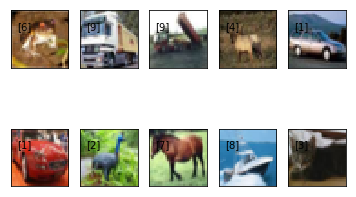

In [5]:
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(X_train[i-1])
    plt.text(3,10,str(y_train[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

##### It is your time to build your model. Try your best to build a model with good performance on the test set.

### 尝试自己构建基于keras的模型

In [6]:
# 通过将每个像素划分为 255 来执行 Cifar10 图像的规范化。下面，训练和测试图像规范化。
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Keras 深度网络模型提供目标变量列表与导出目标变量列表以 sklearn 模型略有不同。
# 虽然您可以为 sklearn 模型提供一维目标变量的列表，但 keras 模型需要 OneHot 代码过程。
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [7]:
# 构建模型，使用序贯模型搭建，就像搭积木一样
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),
                 input_shape=(32, 32,3), 
                 activation='relu', 
                 padding='same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), 
                 activation='relu', padding='same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), 
                 activation='relu', padding='same'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(rate=0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(10, activation='softmax'))

In [8]:
# 显示模型参数摘要
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [9]:
# 编译创建好的模型，网络模型搭建完后，需要对网络的学习过程进行配置，
# 否则在调用 fit 或 evaluate 时会抛出异常
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
train_history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=20, batch_size=128, verbose=1) 

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 11s 284us/step - loss: 1.5421 - acc: 0.4390 - val_loss: 1.3464 - val_acc: 0.5726
Epoch 2/20
40000/40000 [==============================] - 4s 92us/step - loss: 1.1544 - acc: 0.5866 - val_loss: 1.1882 - val_acc: 0.6072
Epoch 3/20
40000/40000 [==============================] - 4s 93us/step - loss: 0.9995 - acc: 0.6478 - val_loss: 1.1375 - val_acc: 0.6256
Epoch 4/20
40000/40000 [==============================] - 4s 90us/step - loss: 0.8888 - acc: 0.6843 - val_loss: 0.9757 - val_acc: 0.6791
Epoch 5/20
40000/40000 [==============================] - 4s 92us/step - loss: 0.8142 - acc: 0.7127 - val_loss: 0.8995 - val_acc: 0.7083
Epoch 6/20
40000/40000 [==============================] - 4s 93us/step - loss: 0.7409 - acc: 0.7388 - val_loss: 0.8185 - val_acc: 0.7319
Epoch 7/20
40000/40000 [==============================] - 4s 89us/step - loss: 0.6907 - acc: 0.7554 - val_loss: 0.8025 - val_a

In [10]:
# 评估模型
score = model.evaluate(X_test,y_test,verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 81us/step
Test score: 0.6640316996097565
Test accuracy: 0.776


In [11]:
# 保存模型
model.save('my_keras_model.h5')

# 保存模型的权重
model.save_weights('my_keras_model_weights.h5')

### VGG16 和 MiniVGG 架构的深层网络架构

In [12]:
# 加载数据
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [13]:
class VGGNet():
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential([
        Conv2D(64, (3, 3), input_shape=(width,height,depth), padding='same',
               activation='relu'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(axis=-1),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same',),
        BatchNormalization(axis=-1),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same',),
        Conv2D(256, (3, 3), activation='relu', padding='same',),
        Conv2D(256, (3, 3), activation='relu', padding='same',),
        BatchNormalization(axis=-1),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        BatchNormalization(axis=-1),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        BatchNormalization(axis=-1),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(classes, activation='softmax')
        ])
        return model

In [14]:
class MiniVGGNet():
    @staticmethod
    def build(width, height, depth, classes):
        model=Sequential()
        # 第一个卷积层
        model.add(Conv2D(32, (3,3), padding="same",input_shape=(width,height,depth)))
        model.add(Activation("relu"))
        # 由于图像形状channels_last，因此为轴=-1。
        model.add(BatchNormalization(axis=-1))
        
        model.add(Conv2D(32, (3,3), padding="same"))
        model.add(Activation("relu"))
        # 由于图像形状channels_last，因此为轴=-1。
        model.add(BatchNormalization(axis=-1))
                  
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        
        # 第二个卷积层       
        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=-1))
        
        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=-1))
        
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        
        # 第一个全连接层
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))       
                  
        # 分类器
        model.add(Dense(classes))
        model.add(Activation('softmax'))
           
        return model     

In [15]:
# 绘制训练过程中训练集和验证集的变化
def show_model_history(modelHistory, model_name):
    history=pd.DataFrame()
    history["Train Loss"]=modelHistory.history['loss']
    history["Validation Loss"]=modelHistory.history['val_loss']
    history["Train Accuracy"]=modelHistory.history['acc']
    history["Validation Accuracy"]=modelHistory.history['val_acc']
    
    fig, axarr=plt.subplots(nrows=2, ncols=1 ,figsize=(12,8))
    axarr[0].set_title("History of Loss in Train and Validation Datasets")
    history[["Train Loss", "Validation Loss"]].plot(ax=axarr[0])
    axarr[1].set_title("History of Accuracy in Train and Validation Datasets")
    history[["Train Accuracy", "Validation Accuracy"]].plot(ax=axarr[1]) 
    plt.suptitle(" Convulutional Model {} Loss and Accuracy in Train and Validation Datasets".format(model_name))
    plt.show()

In [16]:
# 通过将每个像素划分为 255 来执行 Cifar10 图像的规范化。下面，训练和测试图像规范化。
X_train =X_train.astype(np.float32)/255.0
X_test= X_test.astype(np.float32)/255.0

# Keras 深度网络模型提供目标变量列表与导出目标变量列表以 sklearn 模型略有不同。
# 虽然您可以为 sklearn 模型提供一维目标变量的列表，但 keras 模型需要 OneHot 代码过程。
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

### 尝试使用 VGGNet

In [17]:
# 选择VGGNet type 
VGGNet_type = "normal"

if VGGNet_type=="normal":
    print("Normal VGGNet ")
    model=VGGNet.build(width=32, height=32, depth=3, classes=10)
else:
    print("Normal Mini VGGNet")
    model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)


Normal VGGNet 


In [18]:
# 显示模型参数摘要
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
__________

In [19]:
# SGD优化算法
# lr：大或等于0的浮点数，学习率
# momentum：大或等于0的浮点数，动量参数
# decay：大或等于0的浮点数，每次更新后的学习率衰减值
# nesterov：布尔值，确定是否使用Nesterov动量
opt = SGD(lr=0.01, decay=0.01 / 30, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])


In [20]:
# 与测试数据集一起对模型的培训进行训练。这样，将观察模型训练和测试数据集的成功和损失率。
# SGD 优化方法将使用的样本量由 batch_size 参数确定为 128。优化算法由在数据集上运行 40 次的 epochs 参数确定。
# 将详细值分配为 1 会显示在训练模型时日志输出。
modelHistory = model.fit(X_train, y_train, 
                         validation_data=(X_test, y_test),
                         batch_size=128, 
                         epochs=30, 
                         verbose=1)


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 22s 438us/step - loss: 1.4110 - acc: 0.4863 - val_loss: 1.5535 - val_acc: 0.4662
Epoch 2/30
50000/50000 [==============================] - 19s 380us/step - loss: 0.8788 - acc: 0.6896 - val_loss: 1.1509 - val_acc: 0.6039
Epoch 3/30
50000/50000 [==============================] - 19s 377us/step - loss: 0.6533 - acc: 0.7727 - val_loss: 0.7721 - val_acc: 0.7293
Epoch 4/30
50000/50000 [==============================] - 19s 382us/step - loss: 0.4990 - acc: 0.8267 - val_loss: 0.9586 - val_acc: 0.6755
Epoch 5/30
50000/50000 [==============================] - 19s 378us/step - loss: 0.3844 - acc: 0.8673 - val_loss: 0.7292 - val_acc: 0.7536
Epoch 6/30
50000/50000 [==============================] - 19s 375us/step - loss: 0.2903 - acc: 0.9000 - val_loss: 0.8239 - val_acc: 0.7510
Epoch 7/30
50000/50000 [==============================] - 19s 382us/step - loss: 0.2100 - acc: 0.9270 - val_loss: 0.

In [21]:
# 评估模型
score = model.evaluate(X_test,y_test,verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 2s 245us/step
Test score: 1.0303906844854356
Test accuracy: 0.8357


In [22]:
# 保存模型
model.save('VGG16_model.h5')

# 保存模型的权重
model.save_weights('VGG16_model_weights.h5')

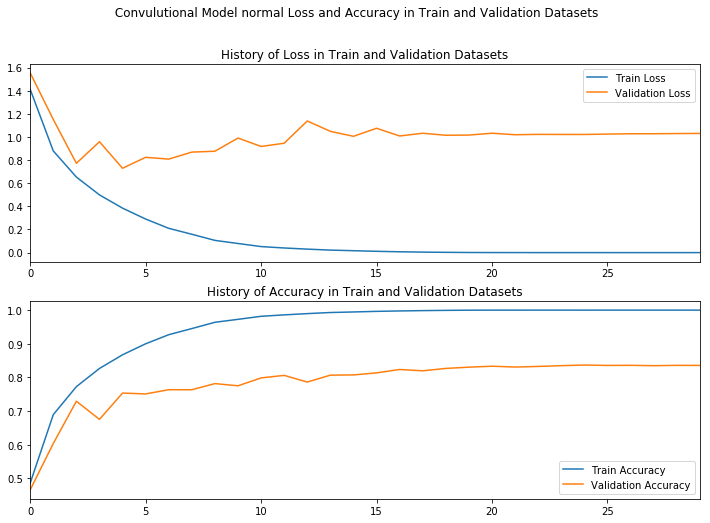

In [23]:
# 绘制训练集和验证训练过程变化图表
show_model_history(modelHistory=modelHistory, model_name=VGGNet_type)

In [24]:
# 对测试数据集进行了预测...
predictions = model.predict(X_test, batch_size=256)

In [25]:
# 分类结果
acc_score=accuracy_score(y_test.argmax(axis=1),predictions.argmax(axis=1))
print("Accuracy score:",acc_score)

class_names=["airplane", "automobile", "bird", "cat", "deer","dog", "frog", "horse", "ship", "truck"]
print("混淆矩阵:\n")
cm=confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(cm)
print("分类报告:\n")
cr=classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1), 
                            target_names=class_names)
print(cr)

Accuracy score: 0.8357
混淆矩阵:

[[876  10  25  18  12   1   5   5  27  21]
 [  6 912   2   3   1   3   5   0  17  51]
 [ 38   2 753  43  59  38  41  14   5   7]
 [ 10   5  58 689  49 107  47  21   4  10]
 [  5   5  36  48 835  20  18  29   4   0]
 [  8   0  30 135  28 751  12  33   1   2]
 [  4   2  27  45  20  10 886   0   5   1]
 [ 11   1  16  33  33  40   4 858   1   3]
 [ 35   7   8  11   4   3   4   1 910  17]
 [ 22  46   5   9   4   1   2   7  17 887]]
分类报告:

              precision    recall  f1-score   support

    airplane       0.86      0.88      0.87      1000
  automobile       0.92      0.91      0.92      1000
        bird       0.78      0.75      0.77      1000
         cat       0.67      0.69      0.68      1000
        deer       0.80      0.83      0.82      1000
         dog       0.77      0.75      0.76      1000
        frog       0.87      0.89      0.88      1000
       horse       0.89      0.86      0.87      1000
        ship       0.92      0.91      0.91  

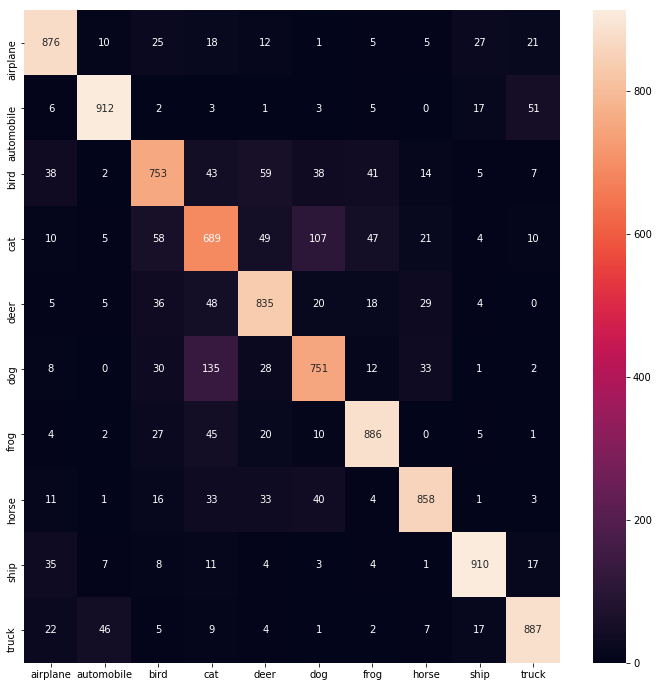

In [26]:
# 绘制混淆矩阵热力图
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True,
           xticklabels=["airplane", "automobile", "bird", "cat", "deer",
                        "dog", "frog", "horse", "ship", "truck"],
            yticklabels=["airplane", "automobile", "bird", "cat", "deer",
                         "dog", "frog", "horse", "ship", "truck"],
            fmt="d"
           )

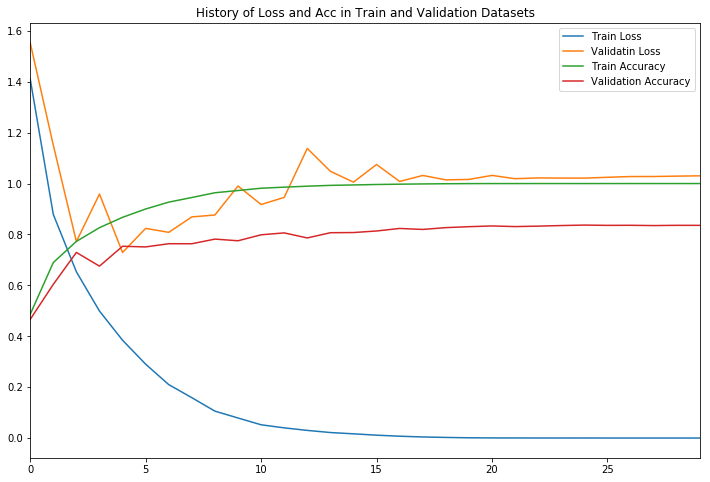

In [27]:
# 通过观察训练集和验证集的acc和loss，可以检查模型行为。

history=pd.DataFrame()
history["Train Loss"]=modelHistory.history['loss']
history["Validatin Loss"]=modelHistory.history['val_loss']
history["Train Accuracy"]=modelHistory.history['acc']
history["Validation Accuracy"]=modelHistory.history['val_acc']

history.plot(figsize=(12,8))
plt.title("History of Loss and Acc in Train and Validation Datasets")
plt.show()

### 尝试使用Mini VGGNet

In [28]:
# 加载数据
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [29]:
# 通过将每个像素划分为 255 来执行 Cifar10 图像的规范化。下面，训练和测试图像规范化。
X_train =X_train.astype(np.float32)/255.0
X_test= X_test.astype(np.float32)/255.0

# Keras 深度网络模型提供目标变量列表与导出目标变量列表以 sklearn 模型略有不同。
# 虽然您可以为 sklearn 模型提供一维目标变量的列表，但 keras 模型需要 OneHot 代码过程。
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [30]:
# 选择Mini VGGNet
print("Normal Mini VGGNet")
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)

Normal Mini VGGNet


In [31]:
# 显示模型参数摘要
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [33]:
opt = SGD(lr=0.01, decay=0.01 / 30, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [34]:
# 与测试数据集一起对模型的培训进行训练。这样，将观察模型训练和测试数据集的成功和损失率。
# SGD 优化方法将使用的样本量由 batch_size 参数确定为 128。优化算法由在数据集上运行 40 次的 epochs 参数确定。
# 将详细值分配为 1 会显示在训练模型时日志输出。
modelHistory = model.fit(X_train, y_train, 
                         validation_data=(X_test, y_test),
                         batch_size=128, 
                         epochs=30, 
                         verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 8s 161us/step - loss: 1.6001 - acc: 0.4558 - val_loss: 1.2929 - val_acc: 0.5373
Epoch 2/30
50000/50000 [==============================] - 6s 124us/step - loss: 1.1162 - acc: 0.6039 - val_loss: 1.0389 - val_acc: 0.6395
Epoch 3/30
50000/50000 [==============================] - 6s 126us/step - loss: 0.9587 - acc: 0.6649 - val_loss: 0.8667 - val_acc: 0.6932
Epoch 4/30
50000/50000 [==============================] - 6s 125us/step - loss: 0.8624 - acc: 0.6969 - val_loss: 0.7891 - val_acc: 0.7252
Epoch 5/30
50000/50000 [==============================] - 6s 124us/step - loss: 0.7978 - acc: 0.7195 - val_loss: 0.7476 - val_acc: 0.7402
Epoch 6/30
50000/50000 [==============================] - 6s 127us/step - loss: 0.7406 - acc: 0.7384 - val_loss: 0.7068 - val_acc: 0.7535
Epoch 7/30
50000/50000 [==============================] - 6s 124us/step - loss: 0.7015 - acc: 0.7521 - val_loss: 0.6700 - 

In [35]:
# 评估模型
score = model.evaluate(X_test,y_test,verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 96us/step
Test score: 0.5592906960964202
Test accuracy: 0.8209


In [36]:
# 保存模型
model.save('Mini_VGG_model.h5')

# 保存模型的权重
model.save_weights('Mini_VGG_model_weights.h5')

In [37]:
# 分类结果
acc_score=accuracy_score(y_test.argmax(axis=1),predictions.argmax(axis=1))
print("Accuracy score:",acc_score)

class_names=["airplane", "automobile", "bird", "cat", "deer","dog", "frog", "horse", "ship", "truck"]
print("混淆矩阵:\n")
cm=confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(cm)
print("分类报告:\n")
cr=classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1), 
                            target_names=class_names)
print(cr)

Accuracy score: 0.8357
混淆矩阵:

[[876  10  25  18  12   1   5   5  27  21]
 [  6 912   2   3   1   3   5   0  17  51]
 [ 38   2 753  43  59  38  41  14   5   7]
 [ 10   5  58 689  49 107  47  21   4  10]
 [  5   5  36  48 835  20  18  29   4   0]
 [  8   0  30 135  28 751  12  33   1   2]
 [  4   2  27  45  20  10 886   0   5   1]
 [ 11   1  16  33  33  40   4 858   1   3]
 [ 35   7   8  11   4   3   4   1 910  17]
 [ 22  46   5   9   4   1   2   7  17 887]]
分类报告:

              precision    recall  f1-score   support

    airplane       0.86      0.88      0.87      1000
  automobile       0.92      0.91      0.92      1000
        bird       0.78      0.75      0.77      1000
         cat       0.67      0.69      0.68      1000
        deer       0.80      0.83      0.82      1000
         dog       0.77      0.75      0.76      1000
        frog       0.87      0.89      0.88      1000
       horse       0.89      0.86      0.87      1000
        ship       0.92      0.91      0.91  

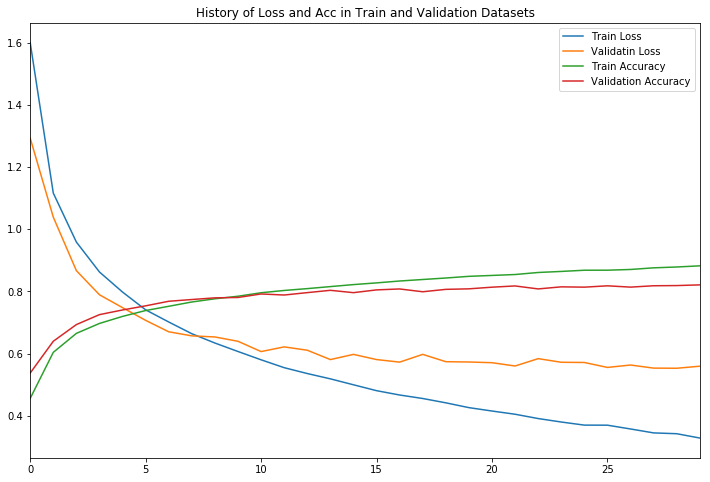

In [38]:
# 通过观察训练集和验证集的acc和loss，可以检查模型行为。

history=pd.DataFrame()
history["Train Loss"]=modelHistory.history['loss']
history["Validatin Loss"]=modelHistory.history['val_loss']
history["Train Accuracy"]=modelHistory.history['acc']
history["Validation Accuracy"]=modelHistory.history['val_acc']

history.plot(figsize=(12,8))
plt.title("History of Loss and Acc in Train and Validation Datasets")
plt.show()

### 尝试使用Mini VGGNet 优化器使用adam

In [39]:
from keras.optimizers import Adam

In [41]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [42]:
# 与测试数据集一起对模型的培训进行训练。这样，将观察模型训练和测试数据集的成功和损失率。
# Adam 优化方法将使用的样本量由 batch_size 参数确定为 128。
# 将详细值分配为 1 会显示在训练模型时日志输出。
modelHistory = model.fit(X_train, y_train, 
                         validation_data=(X_test, y_test),
                         batch_size=128, 
                         epochs=30, 
                         verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 10s 191us/step - loss: 0.6209 - acc: 0.7846 - val_loss: 0.6407 - val_acc: 0.7929
Epoch 2/30
50000/50000 [==============================] - 7s 134us/step - loss: 0.5185 - acc: 0.8179 - val_loss: 0.5958 - val_acc: 0.8037
Epoch 3/30
50000/50000 [==============================] - 7s 132us/step - loss: 0.4627 - acc: 0.8360 - val_loss: 0.5769 - val_acc: 0.8067
Epoch 4/30
50000/50000 [==============================] - 7s 132us/step - loss: 0.4224 - acc: 0.8497 - val_loss: 0.6066 - val_acc: 0.7996
Epoch 5/30
50000/50000 [==============================] - 7s 134us/step - loss: 0.3873 - acc: 0.8630 - val_loss: 0.6116 - val_acc: 0.8002
Epoch 6/30
50000/50000 [==============================] - 7s 135us/step - loss: 0.3573 - acc: 0.8726 - val_loss: 0.5872 - val_acc: 0.8117
Epoch 7/30
50000/50000 [==============================] - 7s 132us/step - loss: 0.3369 - acc: 0.8814 - val_loss: 0.5724 -

In [43]:
# 评估模型
score = model.evaluate(X_test,y_test,verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 107us/step
Test score: 0.6425733012676239
Test accuracy: 0.8341


In [44]:
# 保存模型
model.save('Mini_VGG_model.h5')

# 保存模型的权重
model.save_weights('Mini_VGG_model_weights.h5')

In [45]:
# 分类结果
acc_score=accuracy_score(y_test.argmax(axis=1),predictions.argmax(axis=1))
print("Accuracy score:",acc_score)

class_names=["airplane", "automobile", "bird", "cat", "deer","dog", "frog", "horse", "ship", "truck"]
print("混淆矩阵:\n")
cm=confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(cm)
print("分类报告:\n")
cr=classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1), 
                            target_names=class_names)
print(cr)

Accuracy score: 0.8357
混淆矩阵:

[[876  10  25  18  12   1   5   5  27  21]
 [  6 912   2   3   1   3   5   0  17  51]
 [ 38   2 753  43  59  38  41  14   5   7]
 [ 10   5  58 689  49 107  47  21   4  10]
 [  5   5  36  48 835  20  18  29   4   0]
 [  8   0  30 135  28 751  12  33   1   2]
 [  4   2  27  45  20  10 886   0   5   1]
 [ 11   1  16  33  33  40   4 858   1   3]
 [ 35   7   8  11   4   3   4   1 910  17]
 [ 22  46   5   9   4   1   2   7  17 887]]
分类报告:

              precision    recall  f1-score   support

    airplane       0.86      0.88      0.87      1000
  automobile       0.92      0.91      0.92      1000
        bird       0.78      0.75      0.77      1000
         cat       0.67      0.69      0.68      1000
        deer       0.80      0.83      0.82      1000
         dog       0.77      0.75      0.76      1000
        frog       0.87      0.89      0.88      1000
       horse       0.89      0.86      0.87      1000
        ship       0.92      0.91      0.91  

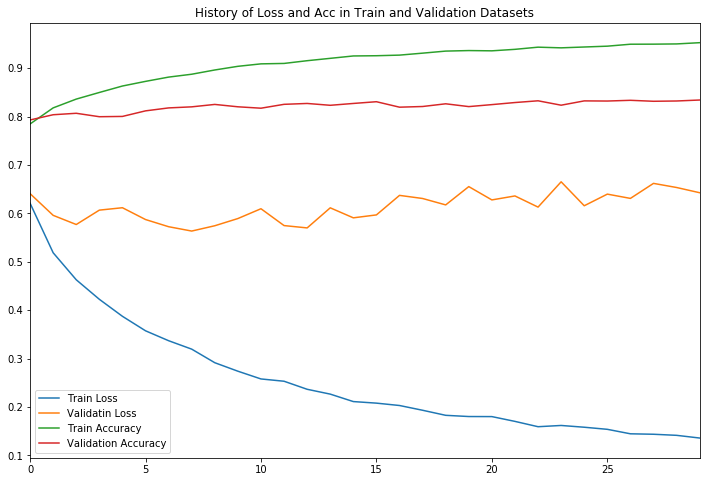

In [46]:
# 通过观察训练集和验证集的acc和loss，可以检查模型行为。

history=pd.DataFrame()
history["Train Loss"]=modelHistory.history['loss']
history["Validatin Loss"]=modelHistory.history['val_loss']
history["Train Accuracy"]=modelHistory.history['acc']
history["Validation Accuracy"]=modelHistory.history['val_acc']

history.plot(figsize=(12,8))
plt.title("History of Loss and Acc in Train and Validation Datasets")
plt.show()

### 4. Optional 

##### Do you want to build a CNN from scratch ? 

In this optianl part, you will build a cnn network step by step.

In [47]:
import numpy as np
np.random.seed(1)

##### 4.1 Implement a convolution step

Hints: Numpy.sum function might be useful.

### 计算单个卷积

In [48]:
def conv_single_step(a_prev_slice,W,b):
    '''
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    Arguments:
    a_prev_slice: slice of input data (shape=(f,f,n_C_prev))
    W: Weight parameters contained in a window. (shape = (f,f,n_C_prev))
    b: Bias parameters contained in a window. (shape=(1,1,1))
    
    Reutrns:
    
    Z: a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data 
    '''
    # Element-wise product
    #print(a_slice_prev.shape,W.shape)
    s = np.multiply(a_prev_slice,W)
    
    # Sum over s  
    Z = np.sum(s)
    
    # Add bias b to z.
    Z = Z + float(b) 
    
    return Z

In [49]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


Use the code above to test your code. If your c
ode is correct, you should be able to get the output shown as below.

<table>
    <tr>
        <td>
            Z
        </td>
        <td>
            -6.99908945068
        </td>
    </tr>

</table>

##### 4.2 Padding

Hints: Numpy.pad function might be useful.

### 往前计算一层卷积

In [50]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X: python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad: integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad: padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """

    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'constant',constant_values=0)
    
    return X_pad

In [51]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1,1])
print ("x_pad[1,1] =\n", x_pad[1,1])

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


Use the code above to test your code. If your code is correct, you should be able to get the output shown as below.

```
x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
```

##### 4.3 Implement a forward propagation in CNN.

Hints: The formulas to calculate the output shapes are :

$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

In [52]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev: output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W: Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b: Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters: python dictionary containing "stride" and "pad"
        
    Returns:
    Z: conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache: cache of values needed for the conv_backward() function
    """
    
    # Get dimensions from A_prev's shape  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Get dimensions from W's shape 
    (f, f, n_C_prev, n_C) = W.shape
    
    # Get information from "hparameters" 
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    # Hint: use int() to apply the 'floor' operation. 
    n_H = np.int(math.floor((n_H_prev + 2 * pad - f) / stride + 1))
    n_W = np.int(math.floor((n_W_prev + 2 * pad - f) / stride + 1))
    
    # Initialize the output volume Z with zeros. 
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]               # Select ith training example's padded activation
        for h in range(n_H):           # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" 
            vert_start = stride * h
            vert_end = vert_start + f
            
            for w in range(n_W):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice"
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                for c in range(n_C):   # loop over channels (= #filters) of the output volume
                                        
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). 
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. 
                    weights = W
                    biases = b
                    
                    Z[i, h, w, c] = conv_single_step(a_slice_prev,W[..., c],b[..., c])
                                                                
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [53]:
import math
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.6923608807576933
Z[3,2,1] =
 [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


Use the code above to test your code. If your code is correct, you should be able to get the output shown as below.

```
Z's mean =
 0.692360880758
Z[3,2,1] =
 [ -1.28912231   2.27650251   6.61941931   0.95527176   8.25132576
   2.31329639  13.00689405   2.34576051]
cache_conv[0][1][2][3] = [-1.1191154   1.9560789  -0.3264995  -1.34267579]
```

##### 4.4 Pooling layers

Hints: As there\'s no padding, the formulas binding the output shape of the pooling to the input shape is:

$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$

$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$

$$ n_C = n_{C_{prev}}$$

In [54]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev: Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters: python dictionary containing "f" and "stride"
    mode: the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A: output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache: cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Get dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Get hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                         # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = h * stride
            vert_end = vert_start + f
            
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current "slice" (≈2 lines)
                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i,vert_start: vert_end, horiz_start:horiz_end,c] 
                    
                    # Compute the pooling operation on the slice. 
                    # Use an if statement to differentiate the modes. 
                    # Use np.max and np.mean.
                    if mode == "max":
                        A[i, h, w, c] =  np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [55]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [

Use the code above to test your code. If your code is correct, you should be able to get the output shown as below.

```
mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[ 1.74481176  0.90159072  1.65980218]
   [ 1.74481176  1.46210794  1.65980218]
   [ 1.74481176  1.6924546   1.65980218]]

  [[ 1.14472371  0.90159072  2.10025514]
   [ 1.14472371  0.90159072  1.65980218]
   [ 1.14472371  1.6924546   1.65980218]]

  [[ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.6924546   2.18557541]]]


 [[[ 1.19891788  0.84616065  0.82797464]
   [ 0.69803203  0.84616065  1.2245077 ]
   [ 0.69803203  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.84616065  1.27375593]
   [ 1.96710175  0.84616065  1.23616403]
   [ 1.62765075  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.86888616  1.27375593]
   [ 1.96710175  0.86888616  1.23616403]
   [ 1.62765075  1.12141771  0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[ -3.01046719e-02  -3.24021315e-03  -3.36298859e-01]
   [  1.43310483e-01   1.93146751e-01  -4.44905196e-01]
   [  1.28934436e-01   2.22428468e-01   1.25067597e-01]]

  [[ -3.81801899e-01   1.59993515e-02   1.70562706e-01]
   [  4.73707165e-02   2.59244658e-02   9.20338402e-02]
   [  3.97048605e-02   1.57189094e-01   3.45302489e-01]]

  [[ -3.82680519e-01   2.32579951e-01   6.25997903e-01]
   [ -2.47157416e-01  -3.48524998e-04   3.50539717e-01]
   [ -9.52551510e-02   2.68511000e-01   4.66056368e-01]]]


 [[[ -1.73134159e-01   3.23771981e-01  -3.43175716e-01]
   [  3.80634669e-02   7.26706274e-02  -2.30268958e-01]
   [  2.03009393e-02   1.41414785e-01  -1.23158476e-02]]

  [[  4.44976963e-01  -2.61694592e-03  -3.10403073e-01]
   [  5.08114737e-01  -2.34937338e-01  -2.39611830e-01]
   [  1.18726772e-01   1.72552294e-01  -2.21121966e-01]]

  [[  4.29449255e-01   8.44699612e-02  -2.72909051e-01]
   [  6.76351685e-01  -1.20138225e-01  -2.44076712e-01]
   [  1.50774518e-01   2.89111751e-01   1.23238536e-03]]]]
```

####  Congratulations! You hanve finished the assignment 6.  You now understand how convolutional neural networks work.

In [ ]:
np.arange(1,10)